In [9]:
# imports
import os
# for the model
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout 
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

# for data manipulation and graphing
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

tf.random.set_seed(42) # set seed for reproducibility
tf.debugging.set_log_device_placement(False)

## Data preprocessing

In [10]:
# load the dataset
original_dataset = pd.read_csv("C:/Users/franc/pasantia_IA/datasets/data-clickup.csv")

# show the original data
original_dataset.head()

,Task ID,Assignee,TotalAssignee,Time Estimate,Time Logged,Mes (drop down),HoursEstimate,HoursLogged
0,3cy8bv6,Andrea Rijana,1,16h 30m,16h 30m,3,16.5,16.5
1,3cy8c35,Andrea Rijana,1,14h,14h,3,14.0,14.0
2,3cy8c62,Andrea Rijana,1,4h 30m,4h 30m,4,4.5,4.5
3,3dv0hrf,Richard Pacheco,1,13h,13h,1,13.0,13.0
4,3dv0ht9,Richard Pacheco,1,6h,6h,1,6.0,6.0


In [11]:
# show the metadata
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Task ID          634 non-null    object 
 1   Assignee         631 non-null    object 
 2   TotalAssignee    634 non-null    int64  
 3   Time Estimate    634 non-null    object 
 4   Time Logged      634 non-null    object 
 5   Mes (drop down)  634 non-null    int64  
 6   HoursEstimate    634 non-null    float64
 7   HoursLogged      634 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 39.8+ KB


In [33]:
# drop all the unnecessary columns
clean_dataset = original_dataset.drop(columns=[
    'Task ID',
    'Assignee',
    'Time Estimate',
    'Time Logged',  
])

# check if is necessary to drop any row with NaN/empty/null values
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TotalAssignee    634 non-null    int64  
 1   Mes (drop down)  634 non-null    int64  
 2   HoursEstimate    634 non-null    float64
 3   HoursLogged      634 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 19.9 KB


### Data sampling

Split the data into train, test and validate samples to fit and evaluate the model

The percentage of each one will be

- 60% training
- 20% testing
- 20% validating

In [34]:
train_dataset, temp_test_dataset = train_test_split(clean_dataset, test_size=0.4)

validation_dataset, test_dataset = train_test_split(temp_test_dataset, test_size=0.20)

print("Samples shape")
print(f"    Train: {train_dataset.shape}")
print(f"    Test: {test_dataset.shape}")
print(f"    Validation: {validation_dataset.shape}")

Samples shape
    Train: (380, 4)
    Test: (51, 4)
    Validation: (203, 4)


### Data analysis

Calculate the correlation and other statistics on the train dataset

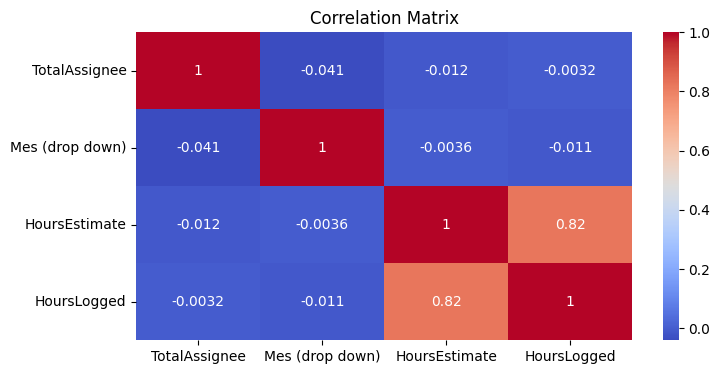

In [35]:
# correlation between the features and the target

correlation_matrix = clean_dataset.corr()
correlation_matrix['HoursLogged'].sort_values(ascending=False)

# plot the correlation matrix
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

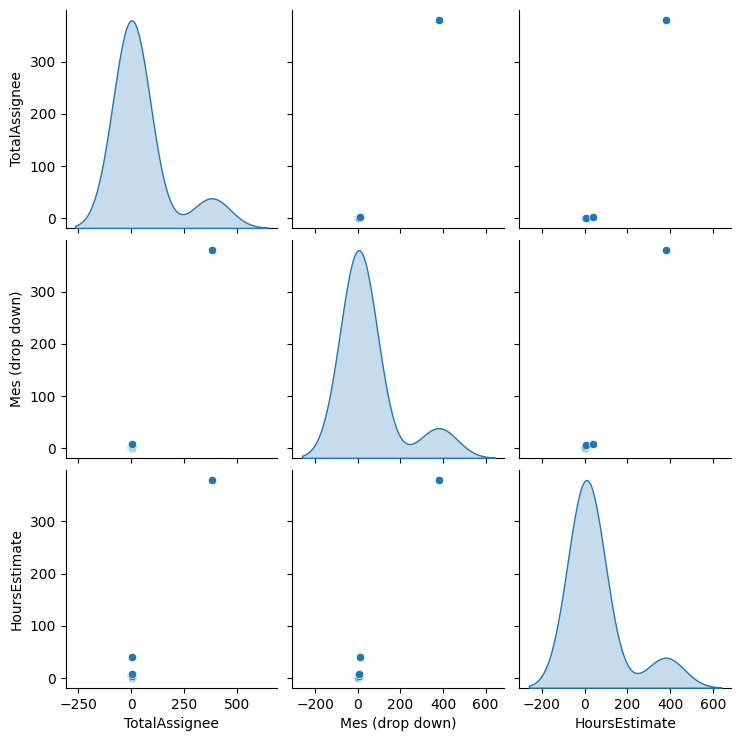

In [36]:
# correlation only between the features 
train_stats = train_dataset.describe()
train_stats.pop("HoursLogged")
sns.pairplot(train_stats[train_stats.columns], diag_kind="kde")

In [37]:
# another interesting statistics 
train_stats = train_dataset.describe()
train_stats.pop("HoursLogged")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
TotalAssignee,380.0,1.005263,0.072452,1.000000,1.0,1.0,1.0000,2.0
Mes (drop down),380.0,4.344737,2.092731,1.000000,3.0,4.0,6.0000,9.0
HoursEstimate,380.0,5.141886,6.072547,0.166667,1.0,3.0,7.3125,40.0


### Feature prediction

The label "Hours Logged" is the actual goal for our model, we will remove it from every sample and keep it apart

In [38]:
train_label = train_dataset.pop('HoursLogged')
test_label = test_dataset.pop('HoursLogged')
validation_label = validation_dataset.pop('HoursLogged')

### Data normalization/Scaling

Subtract the mean of the training data and divide by the standard deviation of the training data.

In [39]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_validation_data = norm(validation_dataset)

In [40]:
# show a part of the normalized data
normed_train_data.head()

,TotalAssignee,Mes (drop down),HoursEstimate
495,-0.072644,0.313114,-0.188041
164,-0.072644,-0.642575,3.105470
616,-0.072644,2.224492,-0.682067
438,-0.072644,0.313114,-0.682067
211,-0.072644,-0.642575,4.093523


## Building the Neural Network Model

## Firts Model
Two hidden layers with 50 neurons each

Learning rate at 0.001

In [41]:
def build_first_model_two_hidden_layers():
    model = Sequential(name = "FirstModelTwoHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(50, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(50, Activation('relu'), name='hidden_layer_2'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )

    return model

### Second Model

Three hidden layers with 32, 64 and 128 neurons, respectively

Learning rate at 0.01

In [42]:
def build_second_model_three_hidden_layers():
    model = Sequential(name = "SecondModelThreeHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(32, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_2'))
    model.add(Dense(128, Activation('relu'), name='hidden_layer_3'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )

    return model

### Choose the model

To choose the model uncomment the line of the one that you want yo fit

In [43]:
model = build_first_model_two_hidden_layers()
# model = build_second_model_three_hidden_layers()

Test the model before training (this will use the initial weights) which in fact will generate random values. We will take the first 10 rows

In [44]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 164ms/step


array([[ 0.12612934],
       [ 0.25441253],
       [ 0.8336539 ],
       [ 0.20114991],
       [ 0.32925165],
       [ 0.01179243],
       [ 0.62918353],
       [ 0.00951844],
       [-0.00341669],
       [ 0.02040142]], dtype=float32)

Save checkpoints during training

In [45]:
checkpoint_path = r".\checkpoint_logs\clickup\data.ckpt"

# Create a callback that saves the model's weights
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', # or val_accuracy if you have it.
                                                 save_best_only=True, # Default false. If you don't change the file name then the output will be overritten at each step and only the last model will be saved.
                                                 save_weights_only=True, # True => model.save_weights (weights and no structure, you need JSON file for structure), False => model.save (saves weights & structure)
                                                 verbose=0,
                                                  )

## Model training

In [61]:
%%time

# for first model
epochs = 800
batch_size = 35

# for second model
# epochs = 500
# batch_size = 40
# for third model

print("Summary of the model")
model.summary()

history = model.fit(
    normed_train_data,
    train_label,
    batch_size=batch_size,  
    epochs=epochs, 
    verbose=0,
    shuffle=True,
    steps_per_epoch = int(normed_train_data.shape[0] / batch_size),
    validation_data=(normed_validation_data, validation_label),
    callbacks=[
        tfdocs.modeling.EpochDots(),
        ckpt_callback,
    ]
)

Summary of the model
Model: "FirstModelTwoHiddenLayers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                40        
                                                                 
 hidden_layer_1 (Dense)      (None, 50)                550       
                                                                 
 hidden_layer_2 (Dense)      (None, 50)                2550      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3191 (12.46 KB)
Trainable params: 3191 (12.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, loss:3.9465,  mae:1.0996,  mse:3.9465,  val_loss:33.6594,  val_mae:2.1921,  val_mse:33.6594,  
............

In [62]:
print("Summary of the results after each epoch:")
history_dataset = pd.DataFrame(history.history)
history_dataset['epoch'] = history.epoch
history_dataset.tail()

Summary of the results after each epoch:


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
795,4.171651,1.077648,4.171651,44.156200,2.285653,44.156200,795
796,4.011229,1.096669,4.011229,39.249615,2.326982,39.249615,796
797,3.416383,0.984343,3.416383,40.057072,2.243398,40.057072,797
798,4.022787,1.120111,4.022787,36.866562,2.311322,36.866562,798
799,4.070325,1.126959,4.070325,40.282196,2.235078,40.282196,799


### Predicted and real values

Here we will see the first 10 rows of the predicted data, comparing it with the real one

In [63]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print("Predicted Hours Logged")
example_result

1/1 [==============================] - 0s 50ms/step
Predicted Hours Logged


array([[ 4.263616  ],
       [26.995945  ],
       [ 2.0414257 ],
       [ 1.3257941 ],
       [-0.17306322],
       [ 3.4029317 ],
       [ 7.2961903 ],
       [ 2.769933  ],
       [ 7.3200197 ],
       [ 5.0992494 ]], dtype=float32)

In [64]:
print("Real Hours Logged")
train_label[:10]

Real Hours Logged


495     4.000000
164    26.000000
616     1.000000
438     0.166667
211     0.500000
191     2.000000
594     8.000000
376     1.150000
62      7.500000
281     0.500000
Name: HoursLogged, dtype: float64

## Evaluating the model

The metrics we choose to evaluate the model were **Mean Abs. Error** and **Mean squarred Error**

We will graph the error metrics across epochs and then see how the model evalutes itself

Text(0, 0.5, 'MAE [Hours Logged]')

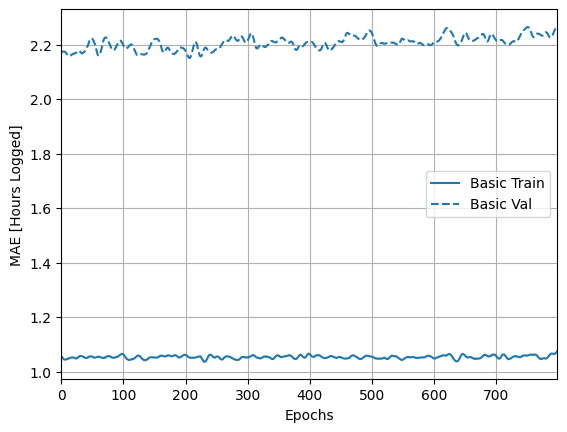

In [65]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Hours Logged]')

In [66]:
print("Error Rate on Train Sample")
loss, mae, mse = model.evaluate(normed_train_data, train_label, verbose=2)

print("Train set Mean Abs Error: {:5.2f} Hours Logged".format(mae))
print("Train set Mean Squared Error: {:5.2f} Hours Logged".format(mse))


Error Rate on Train Sample
12/12 - 0s - loss: 3.5308 - mae: 0.9837 - mse: 3.5308 - 152ms/epoch - 13ms/step
Train set Mean Abs Error:  0.98 Hours Logged
Train set Mean Squared Error:  3.53 Hours Logged


In [67]:
print("Error Rate on Validation Sample")
loss, mae, mse = model.evaluate(normed_validation_data, validation_label, verbose=2)

print("Train set Mean Abs Error: {:5.2f} Hours Logged".format(mae))
print("Train set Mean Squared Error: {:5.2f} Hours Logged".format(mse))

Error Rate on Validation Sample
7/7 - 0s - loss: 40.2822 - mae: 2.2351 - mse: 40.2822 - 82ms/epoch - 12ms/step
Train set Mean Abs Error:  2.24 Hours Logged
Train set Mean Squared Error: 40.28 Hours Logged


## Predicting the data

2/2 [==============================] - 0s 11ms/step


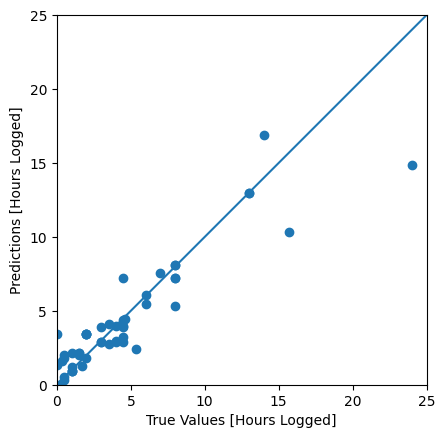

In [68]:
test_predictions = model.predict(normed_test_data).flatten()

axes = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [Hours Logged]')
plt.ylabel('Predictions [Hours Logged]')
lims = [0, 25]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
